In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from scipy.io import arff
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import rcParams
from sklearn.metrics import accuracy_score

# Import the data
# Uncomment exactly one of these lines

arff_data = arff.loadarff('/content/drive/MyDrive/NetworkTrafficNet/ScenarioB/TimeBasedFeatures-Dataset-15s.arff')
# arff_data = arff.loadarff('/content/drive/MyDrive/NetworkTrafficNet/ScenarioB/TimeBasedFeatures-Dataset-15s-AllinOne.arff')
# arff_data = arff.loadarff('/content/drive/MyDrive/NetworkTrafficNet/ScenarioB/TimeBasedFeatures-Dataset-30s.arff')
# arff_data = arff.loadarff('/content/drive/MyDrive/NetworkTrafficNet/ScenarioB/TimeBasedFeatures-Dataset-30s-AllinOne.arff')
# arff_data = arff.loadarff('/content/drive/MyDrive/NetworkTrafficNet/ScenarioB/TimeBasedFeatures-Dataset-60s.arff')
# arff_data = arff.loadarff('/content/drive/MyDrive/NetworkTrafficNet/ScenarioB/TimeBasedFeatures-Dataset-60s-AllinOne.arff')
# arff_data = arff.loadarff('/content/drive/MyDrive/NetworkTrafficNet/ScenarioB/TimeBasedFeatures-Dataset-120s.arff')
# arff_data = arff.loadarff('/content/drive/MyDrive/NetworkTrafficNet/ScenarioB/TimeBasedFeatures-Dataset-120s-AllinOne.arff')

data = pd.DataFrame(arff_data[0])
# The columns are incorrectly labeled. This is our best guess at the correct ordering of the labels
data = data.rename(columns={"total_fiat":"min_fiat", "total_biat":"min_biat", "min_fiat":"max_fiat", "min_biat":"max_biat", "max_fiat":"mean_fiat", "max_biat":"mean_biat", "mean_fiat":"std_fiat","mean_biat":"std_biat"})
print(len(data))
data.head()

18758


,duration,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,std_fiat,std_biat,flowPktsPerSecond,flowBytesPerSecond,min_flowiat,max_flowiat,mean_flowiat,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1
0,9368711.0,16.0,4.0,1564818.0,1549373.0,190205.285714,203290.456522,389822.391917,370323.719754,10.353612,4802.688438,4.0,1523088.0,97590.739583,267600.198443,1871488.0,1.983656e+06,2195089.0,1.832197e+05,1234883.0,1420565.0,1523088.0,161096.539275,b'CHAT'
1,7340238.0,18.0,4.0,1567554.0,1527893.0,165686.977273,186914.846154,317267.548742,304370.651301,11.580006,4340.186245,4.0,1517774.0,87383.785714,221462.862028,1491627.0,3.572433e+06,5653239.0,2.942704e+06,1131498.0,1324636.0,1517774.0,273138.379008,b'CHAT'
2,4644225.0,29.0,15.0,1270547.0,1079974.0,165865.178571,195302.130435,329473.126261,300492.588227,11.412022,4161.512416,15.0,1079974.0,89312.019231,217475.425246,1758922.0,1.758922e+06,1758922.0,0.000000e+00,1079974.0,1079974.0,1079974.0,0.000000,b'CHAT'
3,4978735.0,19.0,8.0,2492050.0,2457286.0,239543.250000,276596.388889,612435.304238,628339.573544,8.034169,3918.666087,8.0,2441990.0,127659.871795,436959.716436,1710925.0,2.382905e+06,3054885.0,9.503232e+05,1346073.0,1894031.5,2441990.0,774930.342317,b'CHAT'
4,11838189.0,19.0,10.0,3094089.0,3093543.0,243766.500000,295954.725000,599721.781709,625632.703972,7.602514,2802.540152,10.0,3042717.0,133013.359551,436129.639296,1747431.0,2.400446e+06,3240696.0,6.232744e+05,1394455.0,1983227.0,3042717.0,725987.829075,b'CHAT'


In [3]:
# One-hot encode the data
one_hot_data = pd.get_dummies(data, columns=['class1'])
one_hot_data.head()

,duration,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,std_fiat,std_biat,flowPktsPerSecond,flowBytesPerSecond,min_flowiat,max_flowiat,mean_flowiat,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1_b'BROWSING',class1_b'CHAT',class1_b'FT',class1_b'MAIL',class1_b'P2P',class1_b'STREAMING',class1_b'VOIP',class1_b'VPN-BROWSING',class1_b'VPN-CHAT',class1_b'VPN-FT',class1_b'VPN-MAIL',class1_b'VPN-P2P',class1_b'VPN-STREAMING',class1_b'VPN-VOIP'
0,9368711.0,16.0,4.0,1564818.0,1549373.0,190205.285714,203290.456522,389822.391917,370323.719754,10.353612,4802.688438,4.0,1523088.0,97590.739583,267600.198443,1871488.0,1.983656e+06,2195089.0,1.832197e+05,1234883.0,1420565.0,1523088.0,161096.539275,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,7340238.0,18.0,4.0,1567554.0,1527893.0,165686.977273,186914.846154,317267.548742,304370.651301,11.580006,4340.186245,4.0,1517774.0,87383.785714,221462.862028,1491627.0,3.572433e+06,5653239.0,2.942704e+06,1131498.0,1324636.0,1517774.0,273138.379008,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,4644225.0,29.0,15.0,1270547.0,1079974.0,165865.178571,195302.130435,329473.126261,300492.588227,11.412022,4161.512416,15.0,1079974.0,89312.019231,217475.425246,1758922.0,1.758922e+06,1758922.0,0.000000e+00,1079974.0,1079974.0,1079974.0,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,4978735.0,19.0,8.0,2492050.0,2457286.0,239543.250000,276596.388889,612435.304238,628339.573544,8.034169,3918.666087,8.0,2441990.0,127659.871795,436959.716436,1710925.0,2.382905e+06,3054885.0,9.503232e+05,1346073.0,1894031.5,2441990.0,774930.342317,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,11838189.0,19.0,10.0,3094089.0,3093543.0,243766.500000,295954.725000,599721.781709,625632.703972,7.602514,2802.540152,10.0,3042717.0,133013.359551,436129.639296,1747431.0,2.400446e+06,3240696.0,6.232744e+05,1394455.0,1983227.0,3042717.0,725987.829075,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
# Separate the data into test and training
train_data = one_hot_data.sample(frac=0.8)
test_data = one_hot_data.drop(train_data.index)

# Separate the labels from the input features
class_columns = ["class1_b'BROWSING'", "class1_b'CHAT'", "class1_b'FT'", "class1_b'MAIL'", "class1_b'P2P'", "class1_b'STREAMING'", "class1_b'VOIP'", "class1_b'VPN-BROWSING'", "class1_b'VPN-CHAT'", "class1_b'VPN-FT'", "class1_b'VPN-MAIL'", "class1_b'VPN-P2P'", "class1_b'VPN-STREAMING'", "class1_b'VPN-VOIP'"]
x_train = train_data.drop(class_columns, axis=1)
y_train = train_data[class_columns]

# Normalize
norm_min = x_train.min()
norm_range = x_train.max() - x_train.min()

x_train = (x_train - norm_min) / norm_range

# Same for test data
x_test = test_data.drop(class_columns, axis=1)
y_test = test_data[class_columns]

# Normalize using the SAME PARAMETERS AS THE TRAINING SET
x_test = (x_test - norm_min) / norm_range

print('Training Data\n', x_train.describe().transpose(), '\n')
print('Test Data\n', x_test.describe().transpose(), '\n')

# Helpful things for testing accuracy later
class_names = ["BROWSING", "CHAT", "FT", "MAIL", "P2P", "STREAMING", "VOIP", "VPN-BROWSING", "VPN-CHAT", "VPN-FT", "VPN-MAIL", "VPN-P2P", "VPN-STREAMING", "VPN-VOIP"]
y_train_probs = tf.identity(y_train).numpy()
y_train_class = np.argmax(y_train_probs, axis=1)
y_test_probs = tf.identity(y_test).numpy()
y_test_class = np.argmax(y_test_probs, axis=1)
rcParams['figure.figsize'] = (9, 9)


Training Data
                       count      mean       std  ...           50%       75%  max
duration            15006.0  0.016412  0.025293  ...  1.847693e-02  0.024851  1.0
min_fiat            15006.0  0.015564  0.058414  ...  1.645401e-06  0.000038  1.0
min_biat            15006.0  0.014010  0.053088  ...  4.883451e-07  0.000035  1.0
max_fiat            15006.0  0.011076  0.036463  ...  9.260785e-04  0.014032  1.0
max_biat            15006.0  0.004820  0.017384  ...  4.658857e-04  0.006995  1.0
mean_fiat           15006.0  0.006543  0.021352  ...  3.258787e-04  0.003423  1.0
mean_biat           15006.0  0.020999  0.057609  ...  8.046424e-04  0.011039  1.0
std_fiat            15006.0  0.004058  0.021392  ...  5.548102e-05  0.002839  1.0
std_biat            15006.0  0.006403  0.027156  ...  1.098228e-04  0.005482  1.0
flowPktsPerSecond   15006.0  0.002072  0.017738  ...  1.175285e-05  0.000101  1.0
flowBytesPerSecond  15006.0  0.000785  0.015923  ...  4.346104e-06  0.000022  1.0
m

In [11]:
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer([len(x_train.keys())], name="Input_Layer"),
  tf.keras.layers.Dense(32, activation='relu', name="dense_01"),
  tf.keras.layers.Dense(48, activation='relu', name="dense_02"),
  tf.keras.layers.Dense(32, activation='relu', name="dense_03"),
  tf.keras.layers.Dense(len(y_train.keys()), activation='softmax', name="Output_Layer")
])

model.compile(Adam(lr=0.002), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_01 (Dense)             (None, 32)                768       
_________________________________________________________________
dense_02 (Dense)             (None, 48)                1584      
_________________________________________________________________
dense_03 (Dense)             (None, 32)                1568      
_________________________________________________________________
Output_Layer (Dense)         (None, 14)                462       
Total params: 4,382
Trainable params: 4,382
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(x_train, y_train, batch_size=256, epochs=1000, validation_split=0.2, verbose=1)

Epoch 1/1000
47/47 [==============================] - 1s 7ms/step - loss: 2.5718 - accuracy: 0.1282 - val_loss: 2.3684 - val_accuracy: 0.2242
Epoch 2/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.3420 - accuracy: 0.2317 - val_loss: 2.2270 - val_accuracy: 0.2675
Epoch 3/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.1882 - accuracy: 0.2782 - val_loss: 2.0222 - val_accuracy: 0.3344
Epoch 4/1000
47/47 [==============================] - 0s 2ms/step - loss: 2.0084 - accuracy: 0.3128 - val_loss: 1.8787 - val_accuracy: 0.3431
Epoch 5/1000
47/47 [==============================] - 0s 2ms/step - loss: 1.8853 - accuracy: 0.3423 - val_loss: 1.8399 - val_accuracy: 0.3654
Epoch 6/1000
47/47 [==============================] - 0s 2ms/step - loss: 1.8387 - accuracy: 0.3389 - val_loss: 1.8306 - val_accuracy: 0.3481
Epoch 7/1000
47/47 [==============================] - 0s 3ms/step - loss: 1.8559 - accuracy: 0.3394 - val_loss: 1.8144 - val_accuracy: 0.3744
Epoch 

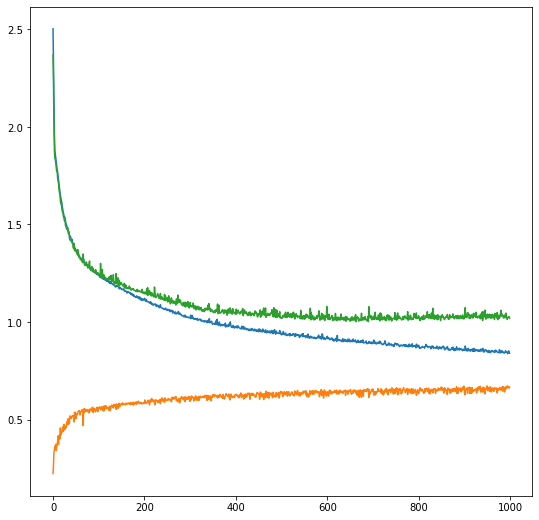

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_accuracy'])
_ = plt.plot(history.history['val_loss'])

0.6647121535181236


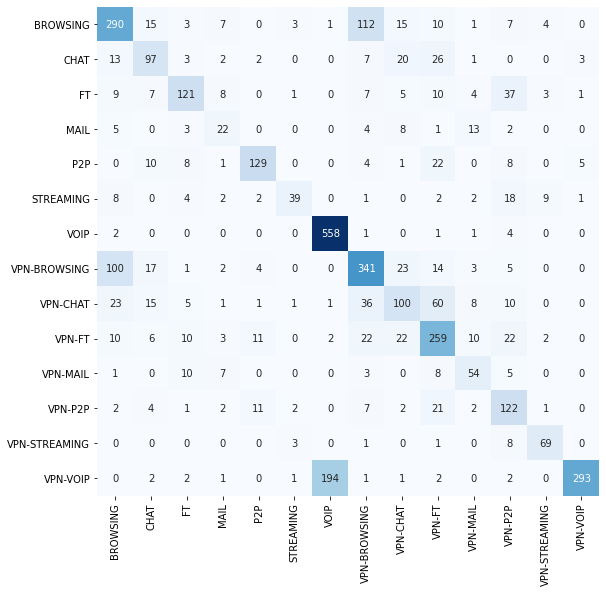

In [14]:
p_test = model.predict(x_test)
p_test_probs = tf.nn.softmax(p_test).numpy()
p_test_class = np.argmax(p_test_probs, axis=1)

print(accuracy_score(p_test_class, y_test_class))
_ = sns.heatmap(tf.math.confusion_matrix(y_test_class, p_test_class), xticklabels=class_names, yticklabels=class_names, cbar=False, cmap='Blues', annot=True, fmt="d")

0.6811275489804078


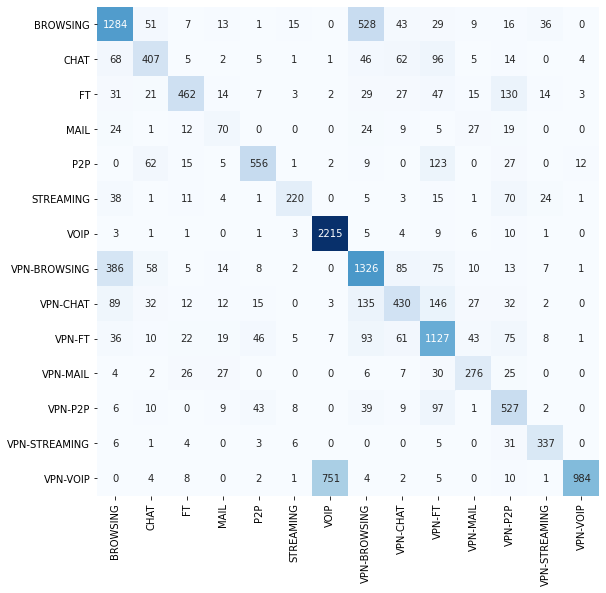

In [15]:
p_train = model.predict(x_train)
p_train_probs = tf.nn.softmax(p_train).numpy()
p_train_class = np.argmax(p_train_probs, axis=1)

print(accuracy_score(p_train_class, y_train_class))
_ = sns.heatmap(tf.math.confusion_matrix(y_train_class, p_train_class), xticklabels=class_names, yticklabels=class_names, cbar=False, cmap='Blues', annot=True, fmt="d")

In [16]:
model.save('/content/drive/MyDrive/NetworkTrafficNet/models/neural_net.h5')

In [17]:
from sklearn import svm
clf = svm.SVC(C=65536.0)
clf.fit(x_train, y_train_class)

SVC(C=65536.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

0.6607142857142857


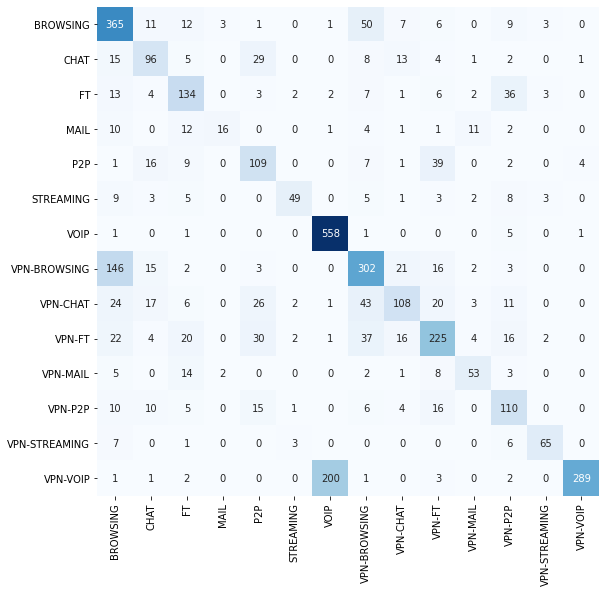

In [18]:
svc_p_test = clf.predict(x_test)
print(accuracy_score(svc_p_test, y_test_class))
_ = sns.heatmap(tf.math.confusion_matrix(y_test_class, svc_p_test), xticklabels=class_names, yticklabels=class_names, cbar=False, cmap='Blues', annot=True, fmt="d")

0.7136478741836598


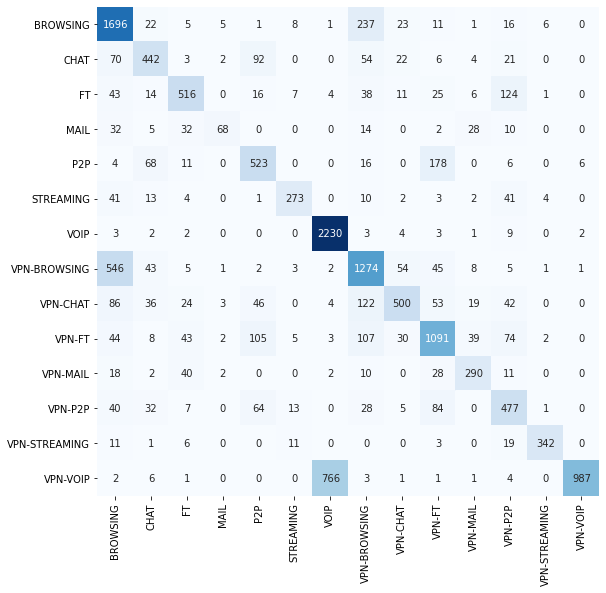

In [19]:
svc_p_train = clf.predict(x_train)
print(accuracy_score(svc_p_train, y_train_class))
_ = sns.heatmap(tf.math.confusion_matrix(y_train_class, svc_p_train), xticklabels=class_names, yticklabels=class_names, cbar=False, cmap='Blues', annot=True, fmt="d")

In [37]:
model2 = tf.keras.Sequential([
  tf.keras.layers.InputLayer([len(x_train.keys())], name="Input_Layer"),
  tf.keras.layers.Dense(len(y_train.keys()), activation='softmax', name="Output_Layer")
])

model2.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Output_Layer (Dense)         (None, 14)                336       
Total params: 336
Trainable params: 336
Non-trainable params: 0
_________________________________________________________________


In [38]:
history2 = model2.fit(x_train, y_train, batch_size=128, epochs=400, validation_split=0.2, verbose=1)

Epoch 1/400
94/94 [==============================] - 1s 5ms/step - loss: 2.5301 - accuracy: 0.1497 - val_loss: 2.3551 - val_accuracy: 0.2735
Epoch 2/400
94/94 [==============================] - 0s 2ms/step - loss: 2.3542 - accuracy: 0.2620 - val_loss: 2.3008 - val_accuracy: 0.2455
Epoch 3/400
94/94 [==============================] - 0s 2ms/step - loss: 2.3090 - accuracy: 0.2465 - val_loss: 2.2723 - val_accuracy: 0.2582
Epoch 4/400
94/94 [==============================] - 0s 3ms/step - loss: 2.2833 - accuracy: 0.2609 - val_loss: 2.2511 - val_accuracy: 0.2722
Epoch 5/400
94/94 [==============================] - 0s 2ms/step - loss: 2.2531 - accuracy: 0.2678 - val_loss: 2.2319 - val_accuracy: 0.2785
Epoch 6/400
94/94 [==============================] - 0s 2ms/step - loss: 2.2478 - accuracy: 0.2667 - val_loss: 2.2149 - val_accuracy: 0.2712
Epoch 7/400
94/94 [==============================] - 0s 3ms/step - loss: 2.2261 - accuracy: 0.2654 - val_loss: 2.1990 - val_accuracy: 0.2785
Epoch 8/400
9

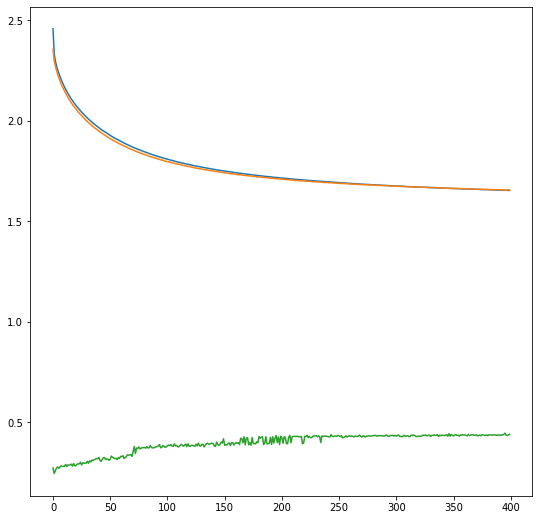

In [39]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
_ = plt.plot(history2.history['val_accuracy'])

0.42590618336886993


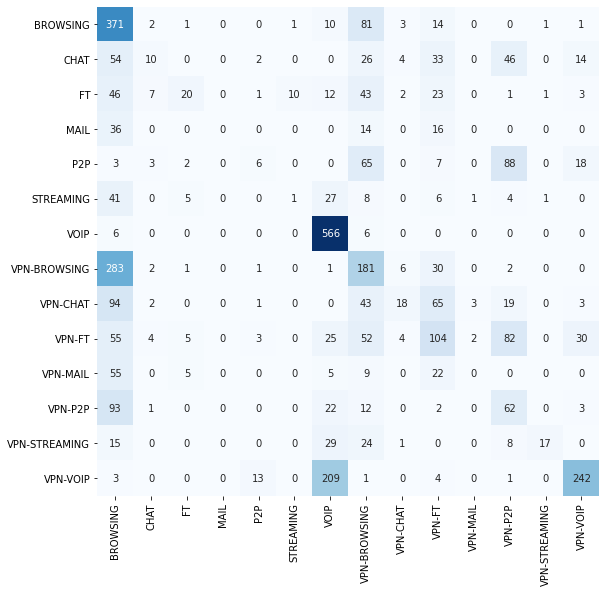

In [40]:
p_test2 = model2.predict(x_test)
p_test_probs2 = tf.nn.softmax(p_test2).numpy()
p_test_class2 = np.argmax(p_test_probs2, axis=1)

print(accuracy_score(p_test_class2, y_test_class))
_ = sns.heatmap(tf.math.confusion_matrix(y_test_class, p_test_class2), xticklabels=class_names, yticklabels=class_names, cbar=False, cmap='Blues', annot=True, fmt="d")

In [41]:
model2.save('/content/drive/MyDrive/NetworkTrafficNet/models/nn_linear.h5')

0.7550639658848614


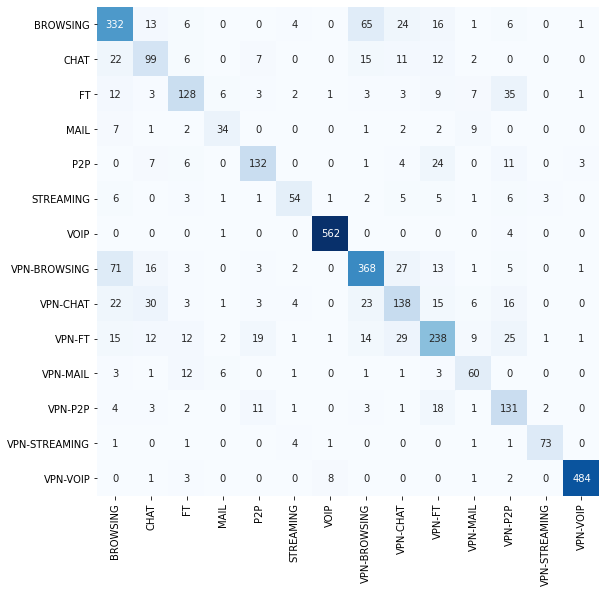

In [22]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(x_train, y_train)
knn_predictions = neigh.predict(x_test)
knn_p_test_probs = tf.identity(knn_predictions).numpy()
knn_p_test_class = np.argmax(knn_p_test_probs, axis=1)

print(accuracy_score(knn_p_test_class, y_test_class))
_ = sns.heatmap(tf.math.confusion_matrix(y_test_class, knn_p_test_class), xticklabels=class_names, yticklabels=class_names, cbar=False, cmap='Blues', annot=True, fmt="d")

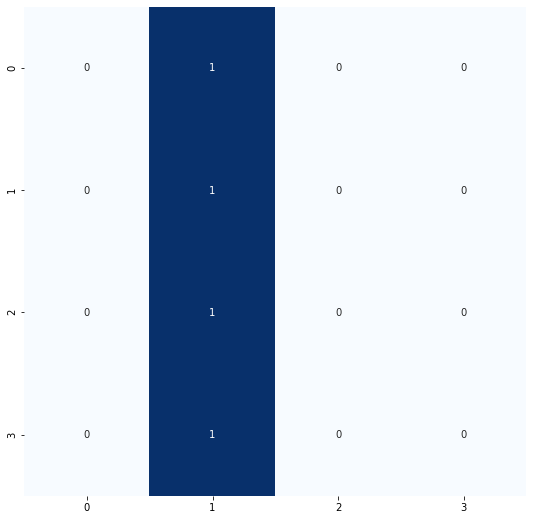

In [43]:
# Just to remind us that the vertical axis is the classification according to the first parameter, and the horizontal is the classification according to the second
_ = sns.heatmap(tf.math.confusion_matrix([0,1,2,3],[1,1,1,1]), cbar=False, cmap='Blues', annot=True, fmt="d")